# Sample notebook

Use this notebook for local experiments. See `scripts/train.py` for Weights & Biases integration.

In [ ]:
%cd ..

In [2]:
from munch import DefaultMunch
import wandb

import numpy as np
import torch
import deepinv as dinv

from utils import *

In [3]:
config = DefaultMunch(
    epochs=10,
    batch_size=1,
    lr_init=1e-3,
    seed=0,
)

torch.manual_seed(config.seed)
np.random.seed(config.seed)
generator = torch.Generator().manual_seed(config.seed)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

Define physics

In [4]:
physics = define_physics(config, device=device, generator=generator)

Prepare dataloaders

In [5]:
train_dataloader, test_dataloader = define_data(config, physics=physics, generator=generator)

Dataset has been saved in Urban100


Define model

In [6]:
model = define_model(config.model, device=device)

Define loss

In [7]:
loss, model = define_loss(config, model=model, device=device)
metrics = define_metrics(config)

Define trainer and train model

Note you can load a pretrained model using `model = load_model(model, model_dir, ckpt_id, device=device)`

In [8]:
optimizer, scheduler = define_optimizer_scheduler(model, config)

trainer = dinv.training.Trainer(
    model = model,
    physics = physics,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    eval_dataloader = test_dataloader,
    epochs = config.epochs,
    losses = loss,
    scheduler = None,
    metrics = metrics,
    online_measurements = False,
    ckp_interval = 1000,
    device = device,
    eval_interval = 1,
    save_path = None,
    plot_images = False,
    wandb_vis = False,
)

trainer.train()

The model has 443 trainable parameters


Eval epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 248.78it/s, PSNR=19.7]


DnCNN(
  (in_conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_list): ModuleList()
  (out_conv): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nl_list): ModuleList(
    (0): ReLU()
  )
)

Plot results

Test:   0%|                                                                                  | 0/20 [00:00<?, ?it/s, PSNR=19.7, PSNR no learning=11.1]

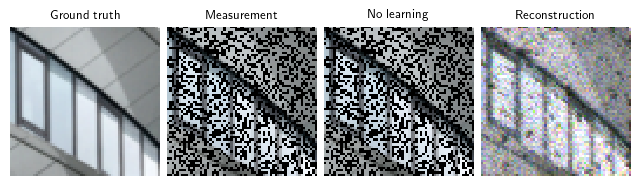

Test: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 63.56it/s, PSNR=19.7, PSNR no learning=11.1]

Test results:
PSNR no learning: 11.100 +- 2.250
PSNR: 19.696 +- 2.488


{'PSNR no learning': 11.10047914981842,
 'PSNR no learning_std': 2.2499061065290054,
 'PSNR': 19.696006774902344,
 'PSNR_std': 2.48835083477134}

In [9]:
trainer.plot_images = True
trainer.test(test_dataloader)